# **Diabetes Prediction Case Study**

**Import python libraries**

In [108]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings("ignore")

### **2. Data Acquisition**

In [109]:
df = pd.read_csv("diabetes.csv")

In [110]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,4,183,0,0,0,28.4,0.212,36,1
1,5,162,104,0,0,37.7,0.151,52,1
2,2,197,70,99,0,34.7,0.575,62,1
3,13,158,114,0,0,42.3,0.257,44,1
4,0,162,76,56,100,53.2,0.759,25,1


#### **Handling Missing Columns & Binning Features**

In [111]:
invalid_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[invalid_cols] = df[invalid_cols].replace(0, np.nan)

In [112]:
# Show missing values per column
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 Pregnancies                   0
Glucose                       3
BloodPressure                27
SkinThickness               167
Insulin                     255
BMI                           9
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


In [113]:
imputer = KNNImputer(n_neighbors=5)
df[invalid_cols] = imputer.fit_transform(df[invalid_cols])


In [114]:
df['GlucoseBin'] = pd.cut(df['Glucose'], bins=[0, 100, 140, np.inf], labels=['Low', 'Normal', 'High'])
df['BPBin'] = pd.cut(df['BloodPressure'], bins=[0, 60, 80, np.inf], labels=['Low', 'Normal', 'High'])

In [115]:
# Show missing values per column
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
GlucoseBin                  0
BPBin                       0
dtype: int64


#### **Handling Outliers**

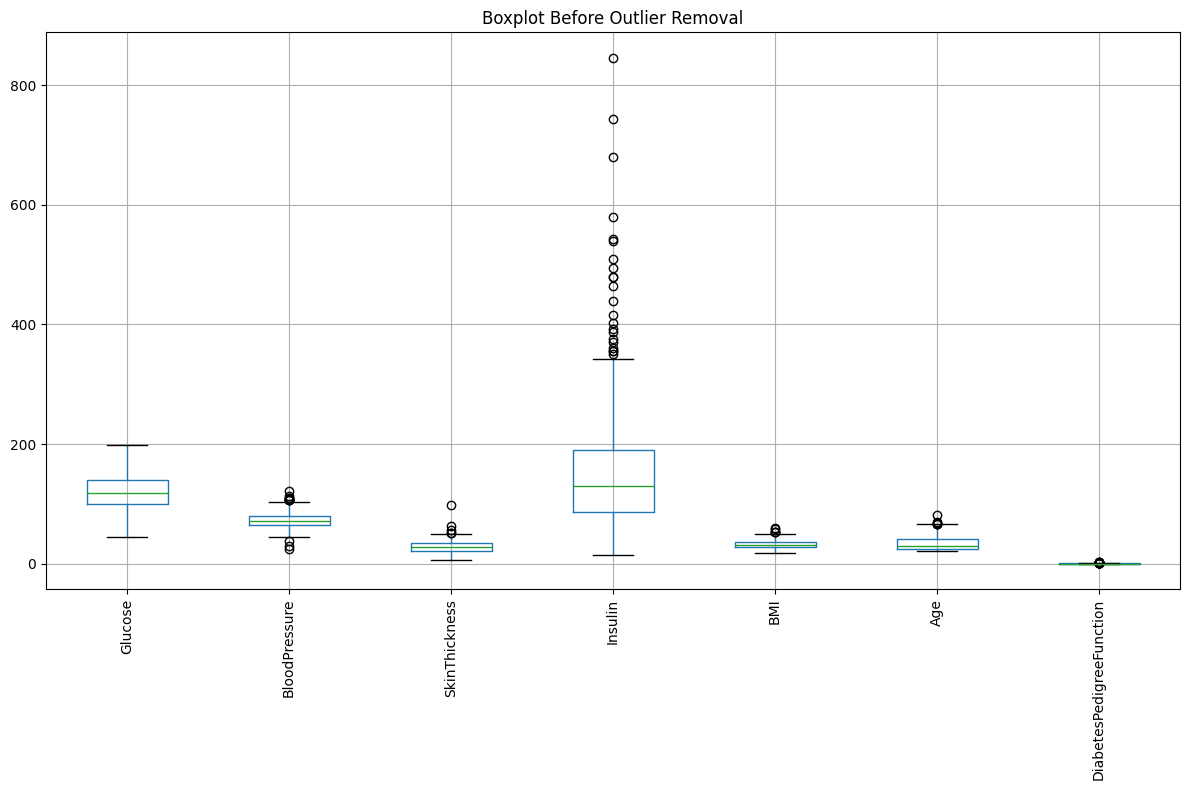


Outliers capped per column (IQR method):
Glucose: Capped 0 outliers
BloodPressure: Capped 12 outliers
SkinThickness: Capped 5 outliers
Insulin: Capped 22 outliers
BMI: Capped 5 outliers
Age: Capped 6 outliers
DiabetesPedigreeFunction: Capped 27 outliers


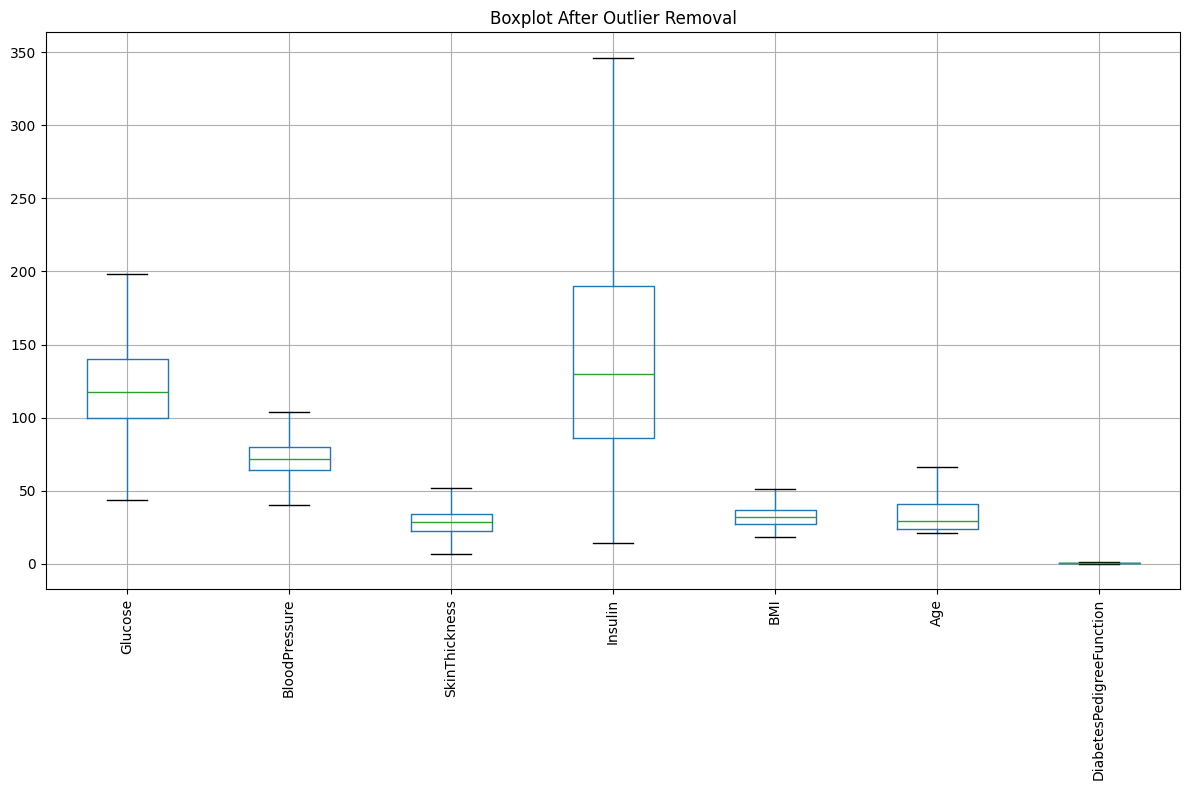

In [116]:
columns_to_check = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age', 'DiabetesPedigreeFunction']

# 1. Visualize outliers before removal
plt.figure(figsize=(12, 8))
df[columns_to_check].boxplot(rot=90)
plt.title("Boxplot Before Outlier Removal")
plt.tight_layout()
plt.show()

# 2. Count and remove outliers
print("\nOutliers capped per column (IQR method):")
for col in columns_to_check:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_below = df[col] < lower_bound
    outliers_above = df[col] > upper_bound

    capped_count = outliers_below.sum() + outliers_above.sum()

    df.loc[outliers_below, col] = lower_bound
    df.loc[outliers_above, col] = upper_bound

    print(f"{col}: Capped {capped_count} outliers")


# 3. Visualize after removing outliers
plt.figure(figsize=(12, 8))
df[columns_to_check].boxplot(rot=90)
plt.title("Boxplot After Outlier Removal")
plt.tight_layout()
plt.show()

### **3. Encoding Categorical Columns**

In [117]:
label_cols = ['GlucoseBin', 'BPBin']
for col in label_cols:
    df[col] = LabelEncoder().fit_transform(df[col])


In [118]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,GlucoseBin,BPBin
0,4,183.0,78.8,27.400,272.8,28.4,0.212,36.0,1,0,2
1,5,162.0,104.0,33.200,289.2,37.7,0.151,52.0,1,0,0
2,2,197.0,70.0,51.775,340.2,34.7,0.575,62.0,1,0,2
3,13,158.0,104.0,36.200,287.4,42.3,0.257,44.0,1,0,0
4,0,162.0,76.0,51.775,100.0,50.9,0.759,25.0,1,0,2


### **4. Feature Scaling**

In [119]:
numerical_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Apply Standard Scaling
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,GlucoseBin,BPBin
0,0.026232,2.017780,0.544835,-0.127987,1.548511,-0.575472,-0.881730,0.231623,1,0,2
1,0.329097,1.326539,2.637474,0.520536,1.749908,0.805450,-1.114363,1.607815,1,0,0
2,-0.579496,2.478608,-0.185927,2.597484,2.376205,0.359992,0.502628,2.467935,1,0,2
3,2.752010,1.194873,2.637474,0.855978,1.727804,1.488487,-0.710116,0.919719,1,0,0
4,-1.185225,1.326539,0.312320,2.597484,-0.573528,2.765470,1.204341,-0.714509,1,0,2


In [120]:
X = df.drop(columns='Outcome')
y = df['Outcome']

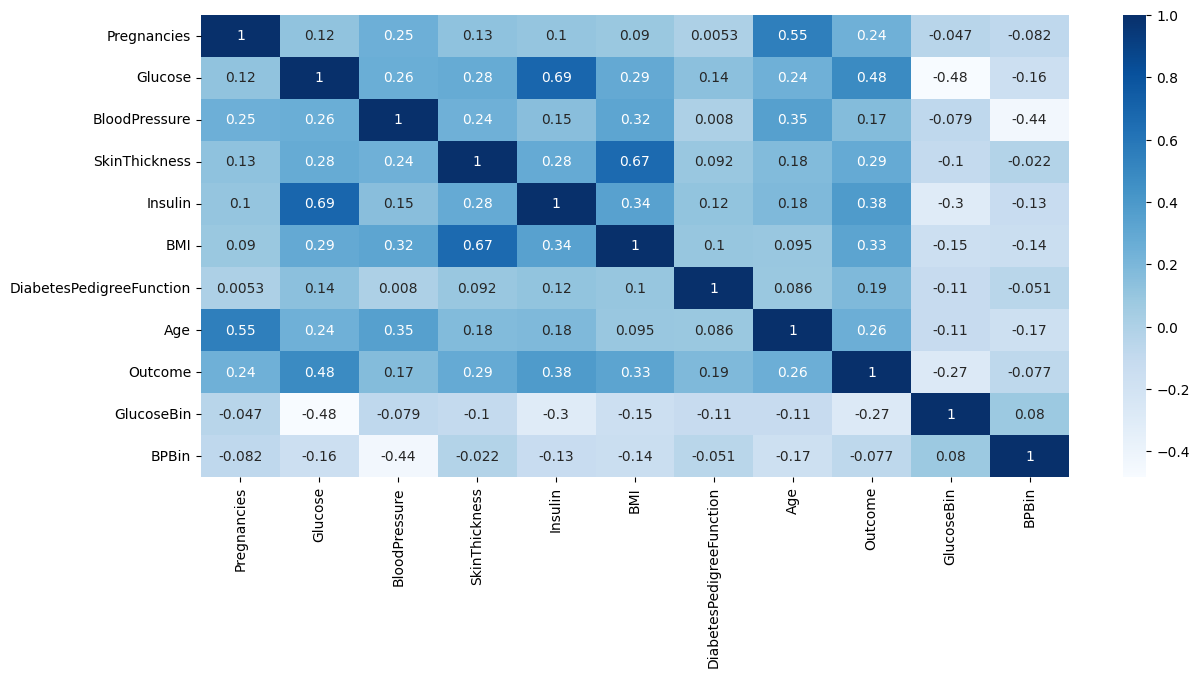

In [121]:
plt.figure(figsize=(14,6))
sns.heatmap(df.corr(), annot=True, cmap='Blues')
plt.show()

In [122]:
for i in df.columns:
    print(i,round(df['Outcome'].corr(df[i]),2))

Pregnancies 0.24
Glucose 0.48
BloodPressure 0.17
SkinThickness 0.29
Insulin 0.38
BMI 0.33
DiabetesPedigreeFunction 0.19
Age 0.26
Outcome 1.0
GlucoseBin -0.27
BPBin -0.08


In [123]:
df=df.drop(['BloodPressure','BPBin'],axis=1)

### **6. Model Development**

#### **i. Model Splitting into Train and Test**
Training Data = 70%, Testing Data = 20%, Validation Set =10%

In [124]:
# Step 1: Split 70% Train and 30% Temp (Test + Holdout)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Step 2: Split 30% Temp into 20% Test and 10% Holdout (2:1 split)
X_test, X_holdout, y_test, y_holdout = train_test_split(
    X_temp, y_temp, test_size=1/3, stratify=y_temp, random_state=42
)

# Confirm shape of each set
print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)
print("Hold-out set:", X_holdout.shape, y_holdout.shape)


Train set: (355, 10) (355,)
Test set: (102, 10) (102,)
Hold-out set: (51, 10) (51,)


In [125]:
# Visualize class imbalance before SMOTE
# sns.countplot(x='Outcome', data=df)
# plt.title("Class Distribution Before SMOTE")
# plt.xlabel("Class")
# plt.ylabel("Count")
# plt.show()
# print("\nClass Distribution before SMOTE:\n", y.value_counts())

In [126]:
# # Apply SMOTE
# smote = SMOTE(random_state=42)
# X, y = smote.fit_resample(X, y)

In [127]:
# # Visualize after SMOTE
# sns.countplot(x=y)
# plt.title("Class Distribution After SMOTE")
# plt.xlabel("Class")
# plt.ylabel("Count")
# plt.show()
# print("\nClass Distribution after SMOTE:\n", pd.Series(y).value_counts())

In [128]:
from sklearn.svm import SVC

#### **ii. Model Training**

In [129]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] # Get probability of the positive class

    # Evaluate the model
    clf_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f"\n--- {name} Results ---")
    print("Classification Report:")
    print(clf_report)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("ROC AUC Score:", roc_auc)
    


Training Logistic Regression...

--- Logistic Regression Results ---
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.85      0.79        67
           1       0.60      0.43      0.50        35

    accuracy                           0.71       102
   macro avg       0.67      0.64      0.65       102
weighted avg       0.69      0.71      0.69       102

Confusion Matrix:
[[57 10]
 [20 15]]
ROC AUC Score: 0.8183368869936034

Training Random Forest...

--- Random Forest Results ---
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.83        67
           1       0.70      0.60      0.65        35

    accuracy                           0.77       102
   macro avg       0.75      0.73      0.74       102
weighted avg       0.77      0.77      0.77       102

Confusion Matrix:
[[58  9]
 [14 21]]
ROC AUC Score: 0.8063965884861408

Training Support Vector Machi

In [130]:
print("\n--- K-Fold Cross-Validation Results (using StratifiedKFold on the full dataset) ---")

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = {}

for name, model in models.items():
    print(f"Performing cross-validation for {name}...")
       scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy') 

    cv_results[name] = {
        'fold_scores': scores,
        'mean_score': np.mean(scores),
        'std_score': np.std(scores)
    }

    print(f"{name} - Cross-Validation Accuracy: {np.mean(scores):.4f}")
    print(f"Individual fold scores: {scores}\n")

print("\n--- Cross-Validation Performance Summary (Mean Accuracy) ---")
for name, res in cv_results.items():
    print(f"{name}: {res['mean_score']:.4f}")


--- K-Fold Cross-Validation Results (using StratifiedKFold on the full dataset) ---
Performing cross-validation for Logistic Regression...
Logistic Regression - Cross-Validation Accuracy: 0.7658
Individual fold scores: [0.76119403 0.73684211 0.77443609 0.79699248 0.7593985 ]

Performing cross-validation for Random Forest...
Random Forest - Cross-Validation Accuracy: 0.8363
Individual fold scores: [0.8358209  0.83458647 0.87218045 0.84210526 0.79699248]

Performing cross-validation for Support Vector Machine...
Support Vector Machine - Cross-Validation Accuracy: 0.7959
Individual fold scores: [0.75373134 0.78947368 0.79699248 0.84962406 0.78947368]

Performing cross-validation for Decision Tree...
Decision Tree - Cross-Validation Accuracy: 0.7327
Individual fold scores: [0.75373134 0.73684211 0.77443609 0.70676692 0.69172932]

Performing cross-validation for K-Nearest Neighbors...
K-Nearest Neighbors - Cross-Validation Accuracy: 0.7778
Individual fold scores: [0.76119403 0.77443609 0.7

#### **iv. Hyperparameter Tuning**

In [131]:
print("\n--- Hyperparameter Tuning for Support Vector Machine (SVC) ---")

param_grid_svc = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

grid_search_svc = GridSearchCV(
    estimator=SVC(probability=True, random_state=42), 
    param_grid=param_grid_svc,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=1,
    n_jobs=-1 
)

print("Performing Grid Search for SVC...")
grid_search_svc.fit(X_train, y_train)

best_params_svc = grid_search_svc.best_params_
best_score_svc = grid_search_svc.best_score_
best_model_svc = grid_search_svc.best_estimator_ # Get the best trained model

print("\nBest Parameters for SVC:", best_params_svc)
print("Best ROC AUC Score from Grid Search (on cross-validation folds):", best_score_svc)

print("\nEvaluating the best SVC model on the test set...")
y_pred_svc = best_model_svc.predict(X_test)
y_proba_svc = best_model_svc.predict_proba(X_test)[:, 1] # Get probability of the positive class

clf_report_svc = classification_report(y_test, y_pred_svc)
conf_matrix_svc = confusion_matrix(y_test, y_pred_svc)
roc_auc_svc = roc_auc_score(y_test, y_proba_svc)

print("\n--- Best SVC Model Test Set Results ---")
print("Classification Report:")
print(clf_report_svc)
print("Confusion Matrix:")
print(conf_matrix_svc)
print("ROC AUC Score:", roc_auc_svc)



--- Hyperparameter Tuning for Support Vector Machine (SVC) ---
Performing Grid Search for SVC...
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Best Parameters for SVC: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best ROC AUC Score from Grid Search (on cross-validation folds): 0.8295948196114707

Evaluating the best SVC model on the test set...

--- Best SVC Model Test Set Results ---
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.85      0.80        67
           1       0.63      0.49      0.55        35

    accuracy                           0.73       102
   macro avg       0.69      0.67      0.68       102
weighted avg       0.72      0.73      0.72       102

Confusion Matrix:
[[57 10]
 [18 17]]
ROC AUC Score: 0.8162046908315566


In [132]:
y_pred = best_model_svc.predict(X_holdout)

print("\nClassification Report (Hold-Out):\n", classification_report(y_holdout, y_pred))
print("\nConfusion Matrix (Hold-Out):\n", confusion_matrix(y_holdout, y_pred))



Classification Report (Hold-Out):
               precision    recall  f1-score   support

           0       0.78      0.94      0.85        33
           1       0.82      0.50      0.62        18

    accuracy                           0.78        51
   macro avg       0.80      0.72      0.74        51
weighted avg       0.79      0.78      0.77        51


Confusion Matrix (Hold-Out):
 [[31  2]
 [ 9  9]]



Confusion Matrix on Hold-Out Set:
[[31  2]
 [ 9  9]]


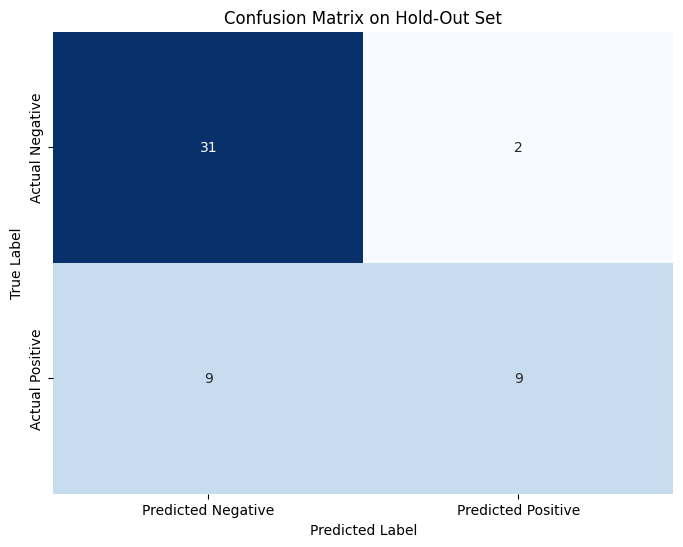

In [133]:
y_pred_holdout = best_model_svc.predict(X_holdout)

conf_matrix_holdout = confusion_matrix(y_holdout, y_pred_holdout)

print("\nConfusion Matrix on Hold-Out Set:")
print(conf_matrix_holdout)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_holdout, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Hold-Out Set')
plt.show()

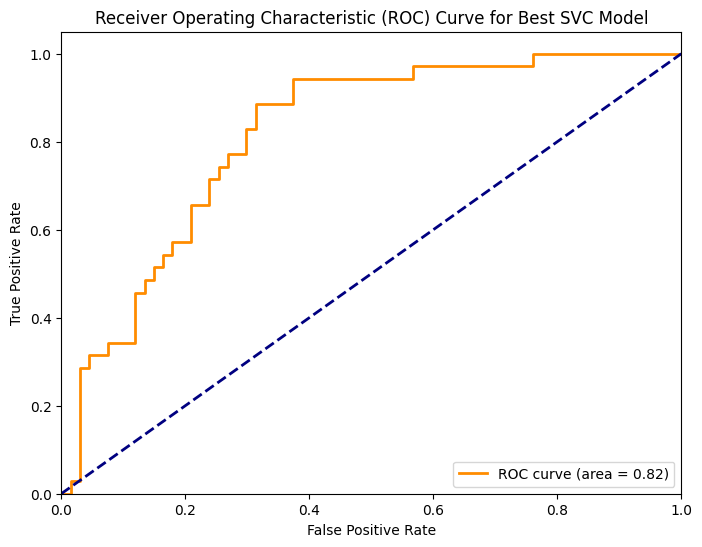

In [134]:
# Get ROC curve points for the best model (SVC)
fpr, tpr, thresholds = roc_curve(y_test, y_proba_svc)
roc_auc = roc_auc_score(y_test, y_proba_svc)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Best SVC Model')
plt.legend(loc="lower right")
plt.show()